# Reducing the number of high fatality accidents
## James Morgan (jhmmorgan)
*2021-12-01*

## 📖 Background
You work for the road safety team within the department of transport and are looking into how they can reduce the number of major incidents. The safety team classes major incidents as fatal accidents involving 3+ casualties. They are trying to learn more about the characteristics of these major incidents so they can brainstorm interventions that could lower the number of deaths. They have asked for your assistance with answering a number of questions.

**One key attribute to point out is that 2020 was an unusual year.  It was the start of the COVID-19 pandemic and from March/April, the start of national lockdowns.  We may therefore see increases or decreases in accidents throughout the year that is not seasonable but instead releated to the amount of traffic seen on the roads.**

## 💾 The data
The reporting department have been collecting data on every accident that is reported. They've included this along with a lookup file for 2020's accidents.

*Published by the department for transport. https://data.gov.uk/dataset/road-accidents-safety-data* 
*Contains public sector information licensed under the Open Government Licence v3.0.*

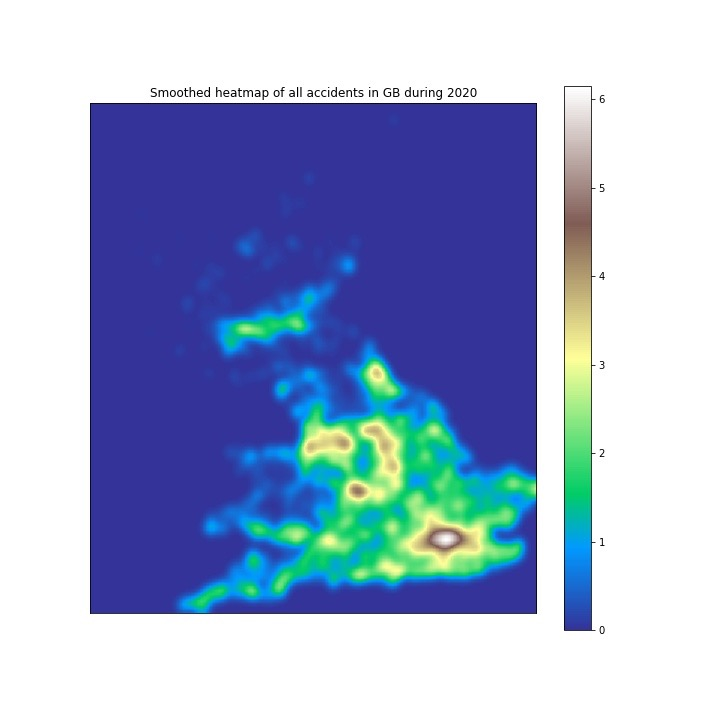

## 1. Set Up
### 1.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation as animation, rc
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

import math

from scipy import ndimage

#from IPython.display import HTML

### 1.2 Default classes
Used for better printing outputs.

In [2]:
# Used for better printing outputs
class formatted:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   HEADER = '\033[1m' + '\033[4m'
   WARNING = '\033[91m' + '\033[1m'
   END = '\033[0m'

def print_fmt(string, attribute = formatted.BOLD, _print = True, _return = False):
    new_string = attribute + string + formatted.END
    if _print:
        print(new_string)
    if _return:
        _return = new_string
        print("test")
    else:
        _return = None
    return _return
def print_bold(string, **kwargs): print_fmt(string, attribute = formatted.BOLD, **kwargs)
def print_underlined(string, **kwargs): print_fmt(string, attribute = formatted.UNDERLINE, **kwargs)
def print_heading(string, **kwargs): print_fmt(string, attribute = formatted.HEADER, **kwargs)
def print_warning(string, **kwargs): print_fmt(string, attribute = formatted.WARNING, **kwargs)

### 1.3 Loading the data
We have two files, **accident-data.csv**, which contains details of all accidents and **road-safety-lookups.csv** which contains mapping for the various values found in the accident data file.

In [3]:
accidents = pd.read_csv(r'./data/accident-data.csv')
print_underlined("Head (first 5 rows) of 'accident-data.csv'")
accidents.head()

Head (first 5 rows) of 'accident-data.csv'


,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,...,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area
0,2020010219808,2020,10219808,-0.254001,51.462262,3,1,1,04/02/2020,3,...,6,0,9,9,1,9,9,0,0,1
1,2020010220496,2020,10220496,-0.139253,51.470327,3,1,2,27/04/2020,2,...,6,0,0,4,1,1,1,0,0,1
2,2020010228005,2020,10228005,-0.178719,51.529614,3,1,1,01/01/2020,4,...,6,0,0,0,4,1,2,0,0,1
3,2020010228006,2020,10228006,-0.001683,51.541210,2,1,1,01/01/2020,4,...,6,0,0,4,4,1,1,0,0,1
4,2020010228011,2020,10228011,-0.137592,51.515704,3,1,2,01/01/2020,4,...,5,0,0,0,4,1,1,0,0,1


In [4]:
lookup = pd.read_csv(r'./data/road-safety-lookups.csv')
print_underlined("Head (first 5 rows) of 'road-safety-lookups.csv'")
lookup.head()

Head (first 5 rows) of 'road-safety-lookups.csv'


,table,field name,code/format,label,note
0,Accident,accident_index,NaN,NaN,unique value for each accident. The accident_i...
1,Accident,accident_year,NaN,NaN,NaN
2,Accident,accident_reference,NaN,NaN,In year id used by the police to reference a c...
3,Accident,longitude,NaN,NaN,Null if not known
4,Accident,Latitude,NaN,NaN,Null if not known


## 2. EDA (Exploratory Data Analysis)

Before we can begin any analysis, we'll need to review what data we hold, identify any missing values and clean up the data we want to use.

This is a data analysis and visualisation task, rather than machine learning.  Typically in machine learning we'd want to normalize the data, i.e. we may want to convert text to meaningful numbers and then scale these values to prevent any bias.

However, for data analysis, we're better off knowing the actual values and so whilst cleaning is needed, we're more interested in the meaning behind the data rather than converting them to numbers.

### 2.1 Data Check

What data types do we have?

In [5]:
# Data Type Check
df_check = pd.DataFrame({"Column": accidents.columns, "Dtype": accidents.dtypes.astype("str").tolist(), 
                         "Sample1": accidents.loc[1].tolist(),
                         "Sample2": accidents.loc[50].tolist(), 
                         "Sample3": accidents.loc[500].tolist()})
print_heading("Data Types for all features in the data")
print(df_check.to_string())

Data Types for all features in the data
                                     Column    Dtype        Sample1        Sample2        Sample3
0                            accident_index   object  2020010220496  2020010228233  2020010229820
1                             accident_year    int64           2020           2020           2020
2                        accident_reference   object       10220496       10228233       10229820
3                                 longitude  float64      -0.139253       0.040169      -0.398137
4                                  latitude  float64      51.470327      51.600893      51.556653
5                         accident_severity    int64              3              3              3
6                        number_of_vehicles    int64              1              2              1
7                      number_of_casualties    int64              2              1              1
8                                      date   object     27/04/2020     02/01/

There's a lot of integers which are actually categorical data. However, before we start to clean our data, do we need to worry about any missing data items?

In [6]:
print_warning("Which features contain null values?")
df_missing = pd.concat([accidents.isnull().sum()[accidents.isnull().sum()>0],round((accidents.isnull().sum()[accidents.isnull().sum()>0]/len(accidents))*100,2)], axis=1)
df_missing.columns = ["No.", "%"]
df_missing

Which features contain null values?


,No.,%
longitude,14,0.02
latitude,14,0.02


Out of the 90k+ records, only 14 have missing data, specifically the longitude and latitude.  Whilst this is a shame, it'll have no baring on our analysis and we're therefore safe to remove this data

In [7]:
accidents.dropna(axis = 0, inplace = True)

Whilst there's no other NA value in the data, do we have features where the record is noted as unknown or not noted?

For example, if the first road number is unknown, it'll be **-1**.

In [8]:
# Features which can contain a minus 1 to mean missing data
features_minus_one = ["first_road_number", "road_type", "speed_limit", "junction_detail", "junction_control", 
                      "second_road_number", "pedestrian_crossing_human_control", "pedestrian_crossing_physical_facilities", 
                      "weather_conditions", "road_surface_conditions", "special_conditions_at_site", "carriageway_hazards",
                      "urban_or_rural_area"]

# Features which can contain a 9 to mean unknown
features_nine      = ["road_type", "junction_control", "pedestrian_crossing_human_control", "pedestrian_crossing_physical_facilities",
                     "weather_conditions", "road_surface_conditions", "special_conditions_at_site", "carriageway_hazards"]

# Features which can contain a 99 to mean unknown
features_nintynine = ["speed_limit", "junction_detail"]

In [9]:
print_heading("Features containing -1 (data missing)")
for feature in features_minus_one:
    feature_count = accidents[accidents[feature] == -1][feature].count()
    if feature_count > 0: print(f"{feature}:" + formatted.RED + formatted.BOLD + f" {feature_count}" + formatted.END)
print()
print_heading("Features containing 9 (data unknown / self reported)")
for feature in features_nine:
    feature_count = accidents[accidents[feature] == 9][feature].count()
    if feature_count > 0: print(f"{feature}:" + formatted.RED + formatted.BOLD + f" {feature_count}" + formatted.END)
print()
print_heading("Features containing 99 (data unknown / self reported)")
for feature in features_nintynine:
    feature_count = accidents[accidents[feature] == 99][feature].count()
    if feature_count > 0: print(f"{feature}:" + formatted.RED + formatted.BOLD + f" {feature_count}" + formatted.END)

Features containing -1 (data missing)
speed_limit: 12
junction_detail: 2
junction_control: 38292
second_road_number: 7
pedestrian_crossing_human_control: 143
pedestrian_crossing_physical_facilities: 135
weather_conditions: 1
road_surface_conditions: 315
special_conditions_at_site: 218
carriageway_hazards: 208

Features containing 9 (data unknown / self reported)
road_type: 2005
junction_control: 1536
pedestrian_crossing_human_control: 3332
pedestrian_crossing_physical_facilities: 2932
weather_conditions: 2421
road_surface_conditions: 847
special_conditions_at_site: 1452
carriageway_hazards: 1191

Features containing 99 (data unknown / self reported)
junction_detail: 1508


Interesting.  Junction_Control stands out as one of the largest feature with missing detail. We may not want to rely on this feature too much to give us information.

We'll need to eventually map all of these features to "unknown". To do this, I'll amend each one to **-2** to provide it's own mapping We'll then map **-2** to **unknown** in the next step.

In [10]:
accidents_clean = accidents.copy()

accidents_clean.loc[accidents_clean["speed_limit"] == -1,"speed_limit"] = -2

for feature in features_minus_one:
    accidents_clean.loc[accidents_clean[feature] == -1,feature] = -2
for feature in features_nine:
    accidents_clean.loc[accidents_clean[feature] ==  9,feature] = -2
for feature in features_nintynine:
    accidents_clean.loc[accidents_clean[feature] == 99,feature] = -2

We're now in a position to clean the data.

1. We can combine and clean some of this data, such as amending the date and time into a single datetime object.
2. In addition to the accident data, we also have a lookup document, which helps us map the data to something meaningful.
        a) For example, an **accident_severity** of 1 is the most severe (fatal) and 3 is the least severe (slight).

In order to get the most use out of, we'll need to clean our data types. 

**Note**
Major incidents are defined as a fatal accident, with 3 or more casualties.
We'll therefore amend the **accident_severity** feature to include a 4th label: "Major".


**_Sub note_**: If we wanted to use machine learning to predict future events, we may want to leave many of these features as integers, however as we're more interested in analytics, converting these to categorical strings will help with visualisations.

In [11]:
# Amend accident_severity to categories and include "Major"
lookup_filtered = lookup[lookup["field name"] == "accident_severity"][["code/format", "label"]].rename(columns = {'label':"accident_severity"})
lookup_filtered["code/format"] = pd.to_numeric(lookup_filtered["code/format"])
lookup_filtered = lookup_filtered.set_index("code/format").to_dict()
accidents_clean.replace(lookup_filtered, inplace = True)
filter_param = ((accidents_clean.number_of_casualties>= 3) & (accidents_clean.accident_severity == "Fatal"))
accidents_clean.loc[filter_param,"accident_severity"] = accidents_clean.loc[filter_param, "accident_severity"].replace("Fatal", "Major")
severity_categories = ["Major", "Fatal", "Serious", "Slight"]
accidents_clean["accident_severity"] = pd.Categorical(accidents_clean["accident_severity"], categories = severity_categories)


# Amend all other features that we can look up
lookup_list = ["day_of_week", "first_road_class", "road_type", "junction_detail", "junction_control", 
               "second_road_class", "pedestrian_crossing_human_control", 
               "light_conditions", "weather_conditions", "road_surface_conditions", "special_conditions_at_site", 
               "carriageway_hazards", "urban_or_rural_area"]

for field in lookup_list:
    lookup_filtered = lookup[lookup["field name"] == field][["code/format", "label"]].rename(columns = {'label':field})
    lookup_filtered["code/format"] = pd.to_numeric(lookup_filtered["code/format"])
    lookup_filtered = lookup_filtered.set_index("code/format").to_dict()
    accidents_clean.replace(lookup_filtered, inplace = True)
    accidents_clean[field] = pd.Categorical(accidents_clean[field])

accidents_clean.replace(-2, "Unknown", inplace = True)


accidents_clean["datetime"] = pd.to_datetime(accidents_clean["date"] + " " + accidents_clean["time"])
accidents_clean["hour"]     = accidents_clean.datetime.dt.hour
accidents_clean["month"]    = accidents_clean.datetime.dt.month
accidents_clean.drop(["date", "time"], axis = 1, inplace = True)
accidents_clean.drop("accident_year", axis = 1, inplace = True)

months_categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
accidents_clean["month"].replace({1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}, inplace = True)
accidents_clean["month"] = pd.Categorical(accidents_clean["month"], categories = months_categories)


day_of_week_categories = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
accidents_clean["day_of_week"] = pd.Categorical(accidents_clean["day_of_week"], categories = day_of_week_categories)


# Data Type Check
df_check = pd.DataFrame({"Column": accidents_clean.columns, "Dtype": accidents_clean.dtypes.astype("str").tolist(), 
                         "Sample1": accidents_clean.loc[1].tolist(),
                         "Sample2": accidents_clean.loc[50].tolist()})
print_heading("Revised data Types for all features in the data")
print(df_check.to_string())

Revised data Types for all features in the data
                                     Column           Dtype                 Sample1                   Sample2
0                            accident_index          object           2020010220496             2020010228233
1                        accident_reference          object                10220496                  10228233
2                                 longitude         float64               -0.139253                  0.040169
3                                  latitude         float64               51.470327                 51.600893
4                         accident_severity        category                  Slight                    Slight
5                        number_of_vehicles           int64                       1                         2
6                      number_of_casualties           int64                       2                         1
7                               day_of_week        category             

Great.  We have no significant missing data, or clearly flagged this as **unknown** and we've cleaned the data into mainly categorical data for ease of reading.

*****************************

### 2.2 Visualising the data
Before we get into the detailed analysis, I'd like to visualise the data.  We have the longitude and latitude of each accident, along with the accidents severity.  Lets visualise this, firstly as a heatmap of all accidents and then as a geospatial map showing the different severities.

##### Heatmap of all accidents

In [12]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='terrain'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.ma.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.gca().invert_yaxis()

    ax.set(xticklabels=[], yticklabels = [])
    ax.tick_params(bottom=False, left = False)
    ax.set(title="Smoothed heatmap of all accidents in GB during 2020")
    plt.colorbar()

    plt.show()

In [13]:
gdf_all = gpd.GeoDataFrame(accidents_clean, geometry=gpd.points_from_xy(accidents_clean.longitude, accidents_clean.latitude))



Look at that! We've not imported a map of Great Britain as we're only working on the data provided, however the volumn of accidents clearly show an outline that represents GB.

There's certainly increases in accidents in key metropolitain areas, such as London and then fewer accidents in Scotland, specifically in the highlands.

#### Visualisation of accidents by severity
Lets now visualise the same data, but as geospatial points, showing the different accident severities.  We'll animate this plot to show the progression of accidents over time from January to December 2020.

* The light pink (lavender blush) points represent the vast number of slight accidents
* The green (olive drab) points represent the high number of serious accidents
* The dark red points represent the few fatal accidents

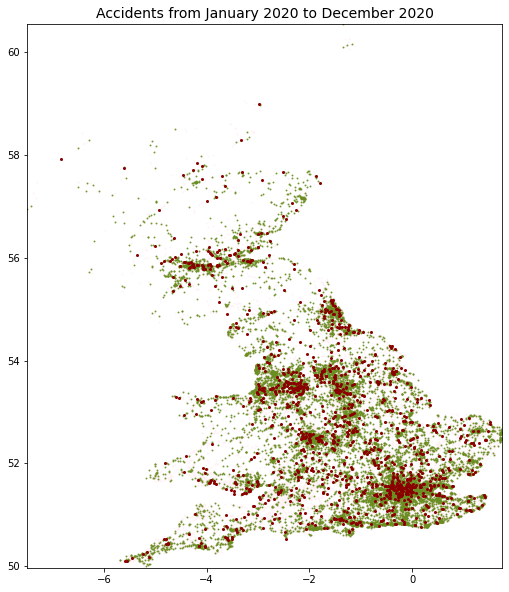

In [14]:
animi_slight = accidents_clean[accidents_clean.accident_severity == "Slight"][["longitude", "latitude", "accident_severity", "datetime"]]
animi_slight = animi_slight.sort_values(by="datetime").reset_index(drop = True)

animi_serious = accidents_clean[accidents_clean.accident_severity == "Serious"][["longitude", "latitude", "accident_severity", "datetime"]]
animi_serious = animi_serious.sort_values(by="datetime").reset_index(drop = True)

animi_fatal = accidents_clean[accidents_clean.accident_severity == "Fatal"][["longitude", "latitude", "accident_severity", "datetime"]]
animi_fatal = animi_fatal.sort_values(by="datetime").reset_index(drop = True)

fig, ax = plt.subplots(figsize=(10, 10))

frames = 100
slight_step  = int(len(animi_slight.index)/frames)
slight_marker = np.linspace(30, 0.5, frames)


def animate(i):
    ax.clear()
    ax.set_xlim((min(accidents_clean.longitude), max(accidents_clean.longitude)))
    ax.set_ylim((min(accidents_clean.latitude), max(accidents_clean.latitude)))
    
    markersize_slight = slight_marker[i]
    
    data_slight   = animi_slight.iloc[:(i+1)*slight_step]
    
    data_slight_date = max(data_slight.datetime)
    data_date_min    = min(accidents_clean.sort_values(by="datetime").datetime).strftime('%B %Y')
    data_date_max    = max(data_slight.sort_values(by="datetime").datetime).strftime('%B %Y')
    
    data_serious  = animi_serious[animi_serious.datetime < data_slight_date]
    data_fatal    = animi_fatal[animi_fatal.datetime < data_slight_date]
    plt.title("Accidents from " + data_date_min + " to " + data_date_max,fontsize=14)

    
    geo_slight    = gpd.GeoDataFrame(data_slight, geometry=gpd.points_from_xy(data_slight.longitude, data_slight.latitude))
    geo_serious   = gpd.GeoDataFrame(data_serious, geometry=gpd.points_from_xy(data_serious.longitude, data_serious.latitude))
    geo_fatal     = gpd.GeoDataFrame(data_fatal, geometry=gpd.points_from_xy(data_fatal.longitude, data_fatal.latitude))

    df_y          = np.mean([min(accidents_clean.longitude), max(accidents_clean.longitude)])

    graph_slight  = geo_slight.plot(ax=ax, alpha = 0.8, color = "lavenderblush", markersize = markersize_slight, aspect = 1/np.cos(df_y * np.pi/180))
    graph_serious = geo_serious.plot(ax=ax, alpha = 0.8, color = "olivedrab", markersize = 1, aspect = 1/np.cos(df_y * np.pi/180))
    graph_fatal   = geo_fatal.plot(ax=ax, alpha = 1, color = "darkred", markersize = 4, aspect = 1/np.cos(df_y * np.pi/180))    
    
ani = animation.FuncAnimation(fig, animate, frames=frames,interval=250,repeat=True, cache_frame_data = False)
#HTML(ani.to_html5_video())
rc('animation', html='html5')
ani

In [15]:
animi_heatmap = accidents_clean[["longitude", "latitude", "accident_severity", "datetime"]].sort_values(by="datetime").reset_index(drop = True)
frames = 200
interval = 50
heatmap_step  = int(len(animi_heatmap.index)/frames)

#fig, ax = plt.subplots(figsize=(7, 7))


def animate(i):
    ax.clear()
    ax.set_xlim((min(accidents_clean.longitude), max(accidents_clean.longitude)))
    ax.set_ylim((min(accidents_clean.latitude), max(accidents_clean.latitude)))
    
    
    data             = animi_heatmap.iloc[((i+1)*heatmap_step-heatmap_step):(i+1)*heatmap_step]
    d                = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
    
    data_date_min    = min(data.sort_values(by="datetime").datetime).strftime('%d %B %Y')
    data_date_max    = max(data.sort_values(by="datetime").datetime).strftime('%d %B %Y')

    plt.title("Accidents from " + data_date_min + " to " + data_date_max,fontsize=14)
    
    bins = 75
    smoothing = 1.75
    cmap = "terrain"
    
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.ma.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    #plt.gca().invert_yaxis()

    ax.set(xticklabels=[], yticklabels = [])
    ax.tick_params(bottom=False, left = False)
    ax.set(title="Accidents from " + data_date_min + " to " + data_date_max)
    
    cmap_col = matplotlib.cm.get_cmap('terrain')
    rgba = cmap_col(0)
    ax.set_facecolor(rgba)
    
#animate(1)
#ani = animation.FuncAnimation(fig, animate, frames=frames,interval=interval,repeat=True, cache_frame_data = False)
#rc('animation', html='html5')
#ani

## 3. Gaining insight from our data

We're interested in the major incidents
* Major incidents are defined as a fatal accident, with 3 or more casualties.

We need to understand how major incidents differ to non major (but still fatal) incidents.  However, I also believe it's important to understand the difference between fatal accidents to non fatal (serious or slight accidents).

We'll therefore not only analyse major incidents, we'll also compare this to all fatal, all serious and all slight accidents.

**Only a small % of fatal accidents are considered a major incident and so we can expect to see some volatility in the data and this might explain some of the difference between major incidents and fatal accidents.**

Let's first visualise how the different categorical features of our data differ when compared to the accident severity.

In [16]:
categorical_features = ['day_of_week', 'month', 'first_road_class', 'road_type', 'speed_limit', 
                        'junction_control', 'second_road_class', 
                        'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 
                        'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 
                        'urban_or_rural_area']
print(formatted.BOLD + f'Categorical Features ({len(categorical_features)}):' + formatted.END + f'\n{categorical_features}')

Categorical Features (14):
['day_of_week', 'month', 'first_road_class', 'road_type', 'speed_limit', 'junction_control', 'second_road_class', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'urban_or_rural_area']


In [17]:
def categorical_plot(df, feature, _compare_to = "accident_severity"):
    if (df[feature].dtype.name == "category"):
        feature_len = len(df[feature].cat.categories)
    else:
        feature_len = len(df[feature].unique())


    #feature_len = len(df[feature].cat.categories)
    r = np.arange(0, feature_len, 1)
    
    feature_count = df[[_compare_to, feature]].groupby([feature, _compare_to]).size().reset_index()
    feature_count.columns = ["feature", "_compare_to", "count"]
    feature_count = feature_count.pivot(index = "feature", columns = "_compare_to", values = "count")
    
    if (df[_compare_to].dtype.name == "category"):
        _compare_list = df[_compare_to].cat.categories.values
    else:
        _compare_list = df[_compare_to].unique()

    if (df[feature].dtype.name == "category"):
        _feature_list = df[feature].cat.categories.values
    else:
        _feature_list = df[feature].unique()


        
    totals = feature_count.sum(axis = 1)
    print_underlined(feature + " vs " + _compare_to)
    bars = []
    barWidth = 0.85
    names = _feature_list

    fig, axes = plt.subplots(1,4, figsize = (25,4), sharex=True)
    fig.text(0.5, 0, feature, ha='center')
    
    for i, item in enumerate(_compare_list):
        new_bar = [i / t * 100 for i, t in zip(feature_count[item], totals)]
        bars.append(new_bar)
        axes[i].bar(r, feature_count[item], alpha = 0.5)
        axes[i].plot(r, feature_count[item], marker = "o", color = "red")
        axes[i].set_title(item)
        plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=80)
    axes[0].set_ylabel("Count")
    
    plt.xticks(r, names)
    plt.tight_layout()
    plt.show()


Plots for categories vs accident_severity

day_of_week vs accident_severity


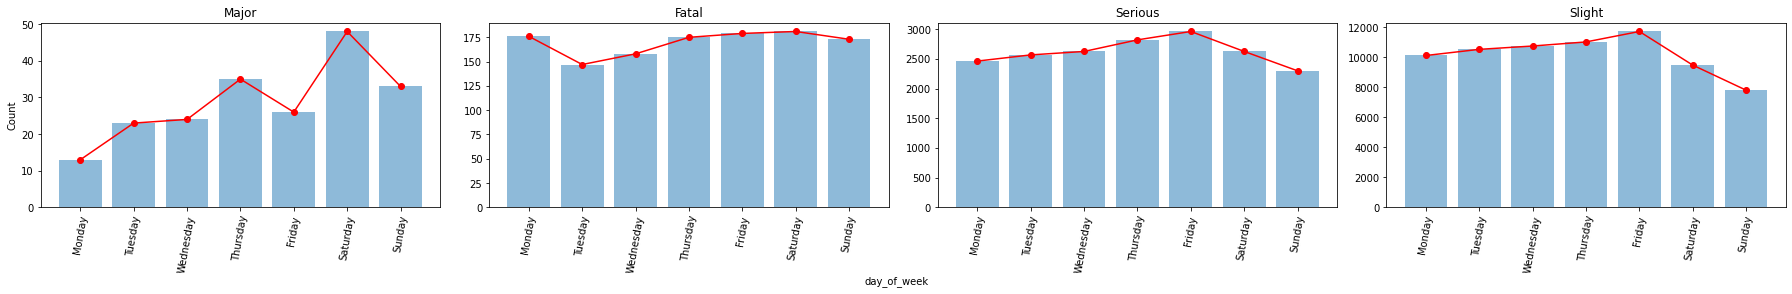

month vs accident_severity


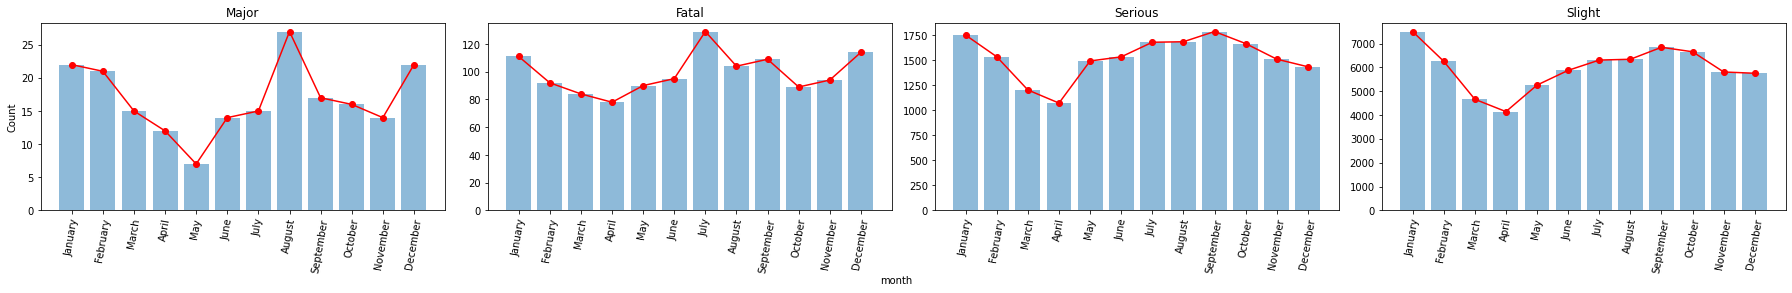

first_road_class vs accident_severity


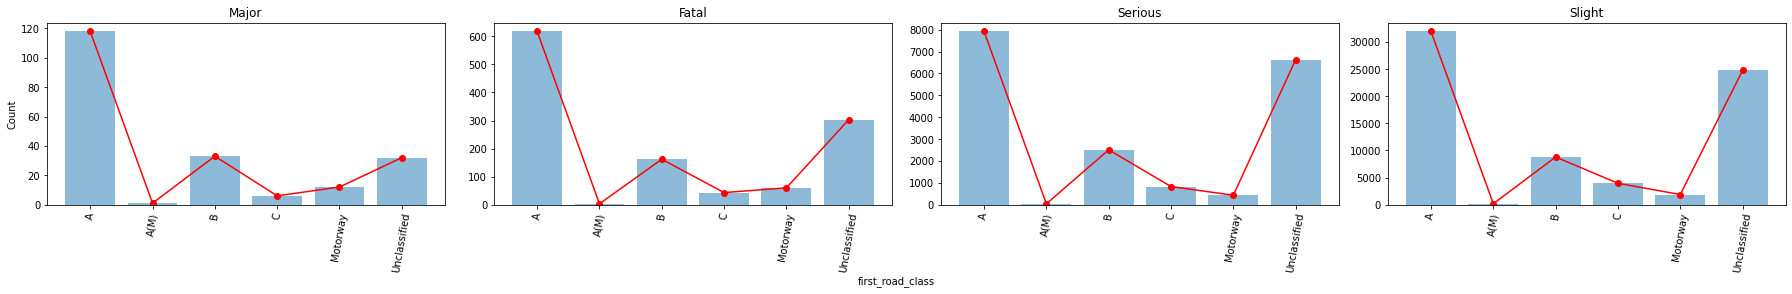

road_type vs accident_severity


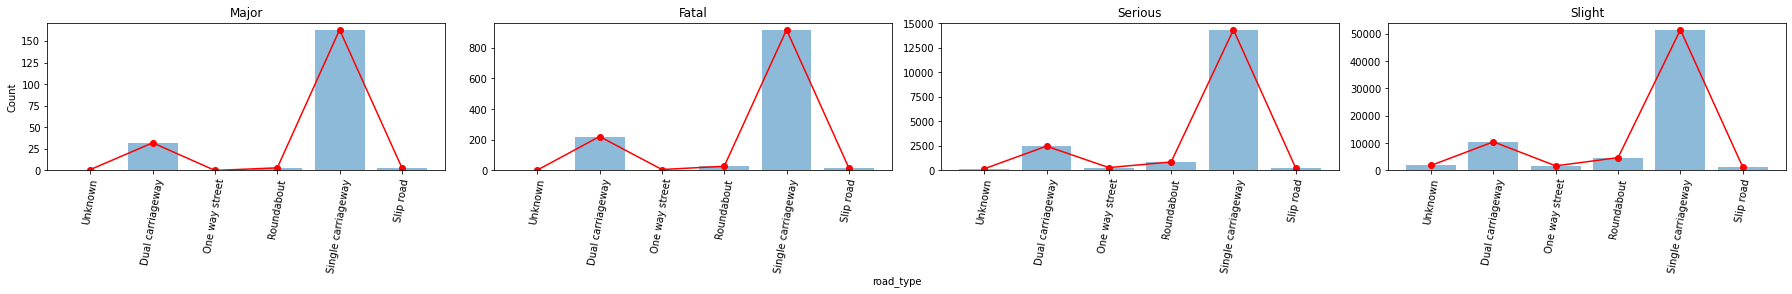

speed_limit vs accident_severity


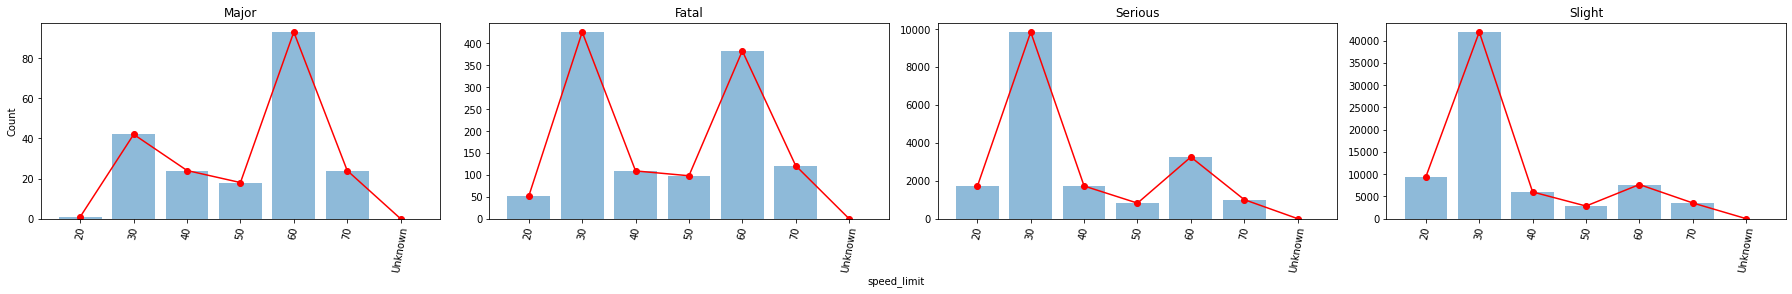

junction_control vs accident_severity


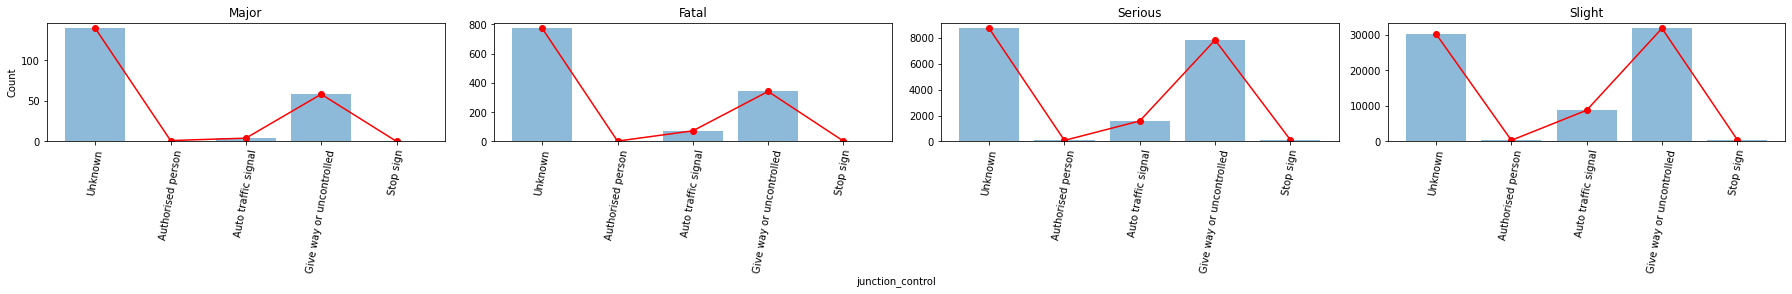

second_road_class vs accident_severity


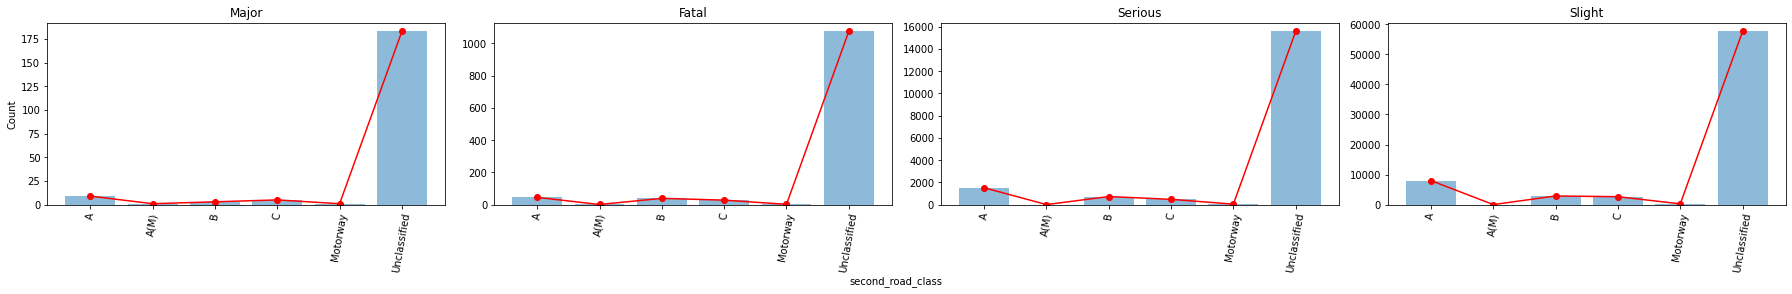

pedestrian_crossing_human_control vs accident_severity


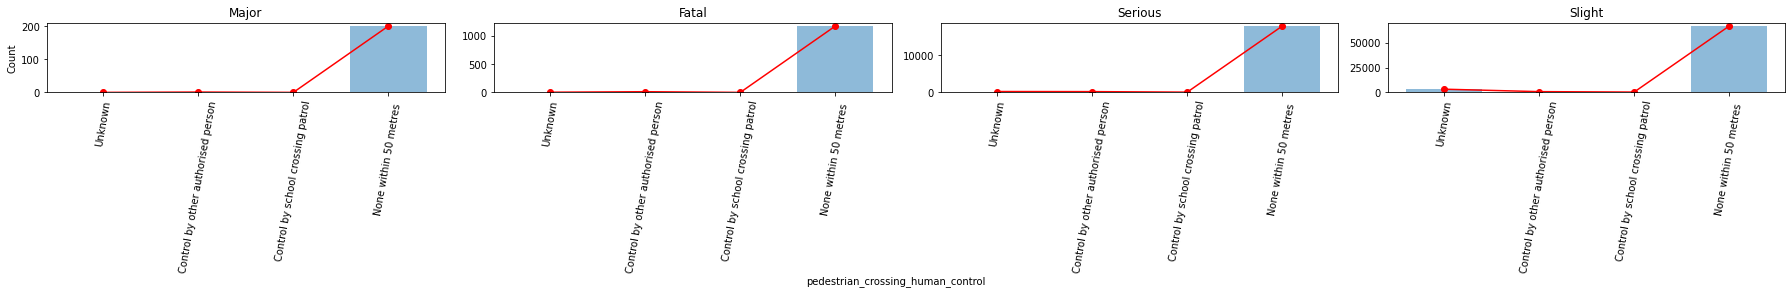

pedestrian_crossing_physical_facilities vs accident_severity


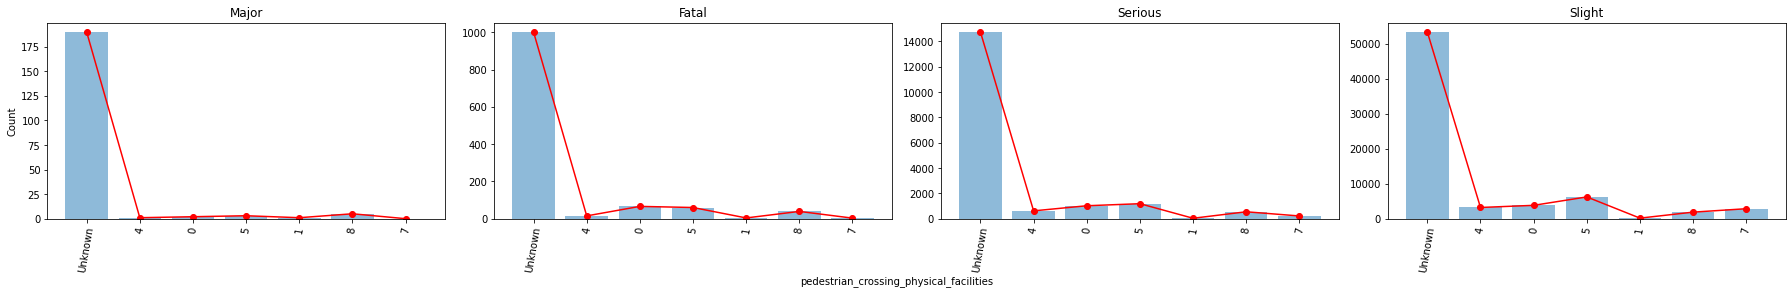

light_conditions vs accident_severity


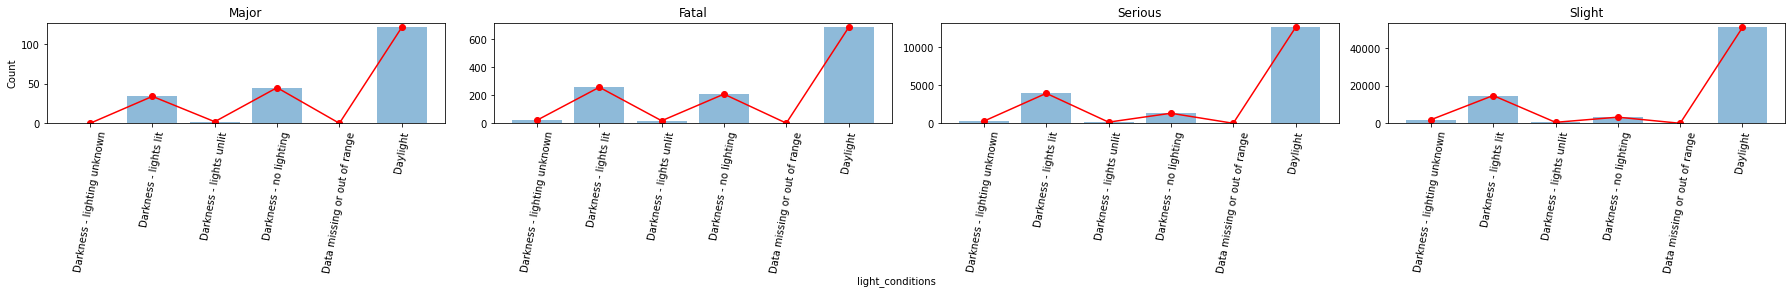

weather_conditions vs accident_severity


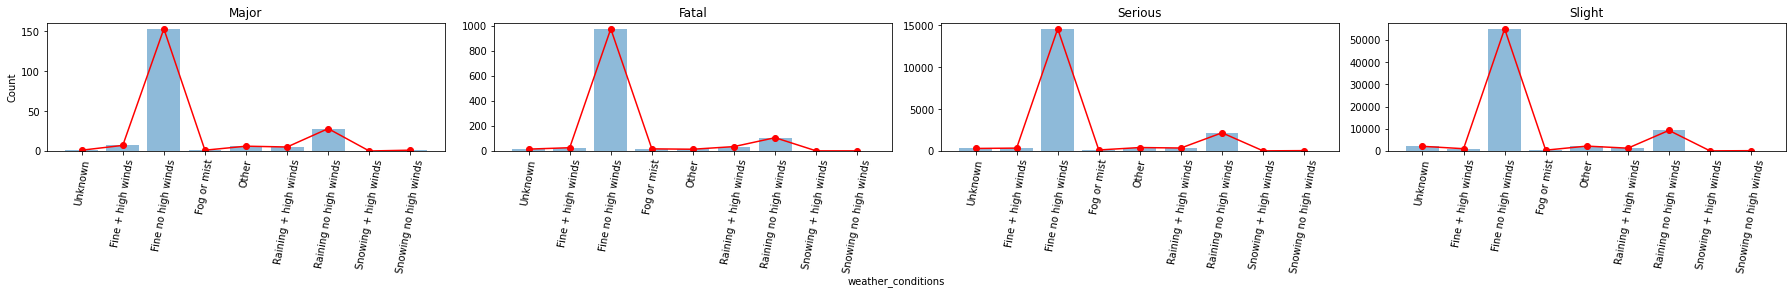

road_surface_conditions vs accident_severity


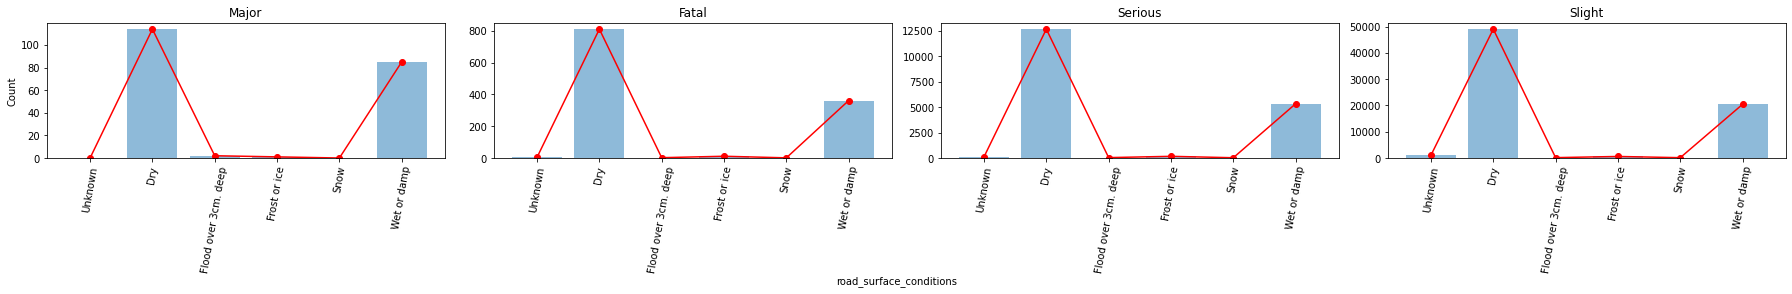

special_conditions_at_site vs accident_severity


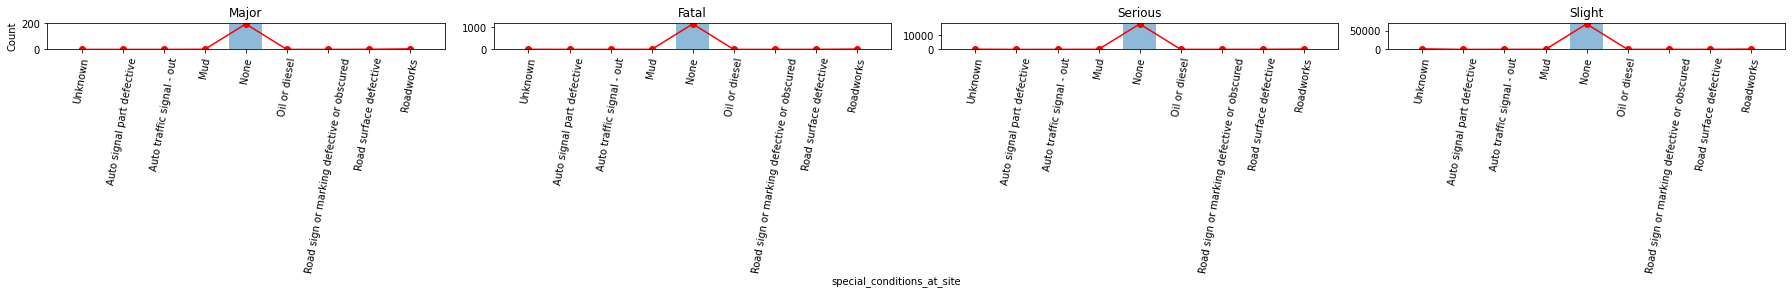

urban_or_rural_area vs accident_severity


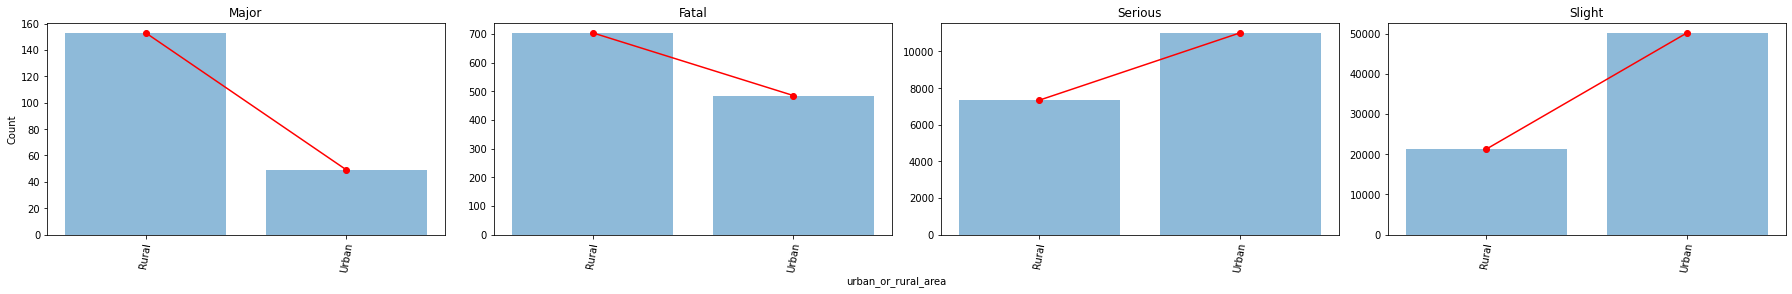

In [18]:
print_heading("Plots for categories vs accident_severity")
print()
for category in categorical_features:
    categorical_plot(accidents_clean, category)

**Analysis of plots**

This is really interesting.  As expected, there are a lot more **slight** accidents followed by there being more **serious** accidents.  Finally, there are only a few (but still too many) **fatal** accidents, including major incidents.

For most features, the trend is the same, i.e. what causes an increase in **slight** accidents, also causes an increase in **serious** and **fatal** accidents.  However, there are also a few features that relate to **fatal** accidents or **major incidents** more.

_Features that contribute to any type of accident_

* There are more accidents in January, July, August, September and December.
    * This might be more to do with holiday seasons, or (for December and January), the winter months.
    * **Or this imght be due to the increased traffic seen prior to lockdown, or during the breaks between lockdowns.**
* Class A roads experience more accidents than other road types.
* Single Carriageways experience more accidents than other types of roads.
    * If I had to make assumptions, this would be because any overtaking would be on the opposite side of the road, with the potential for oncoming traffic.
* A speed limit of 30mph results in more accidents generally.
* An unknown or give way / uncontrolled junction tends to see more accidents.
* There are more accidents during the day time.
    * Maybe due to the increased volume of traffic during daylight hours.

_Features that contriubte more to a fatal accident_
* There are more fatal accidents on a Saturday (Whereas there are more serious or slight accidents on a Friday).
* Fatal accidents are more likely to occur in July or December.
* In addition to a speed limit of 30mph, there is a significant increase in fatal accidents at 60mph.
* There is a bigger increase in fatal accidents when it's dark.
* There are more fatal accidents in rural areas, whereas there are more serious or slight accients in urban areas.

_Features that contribute more to a major incident compred to fatal accidents_
* Whilst most accidents are on Saturday, there are more major incidents on a Thursday and a lot fewer on a Monday.
* Major incidents are more likely to occur in August, compared to July or December.
* Most major incidents are at 60mph, with fewer at 30mph.

Bar Plots of accidents vs the number of vehicals involved


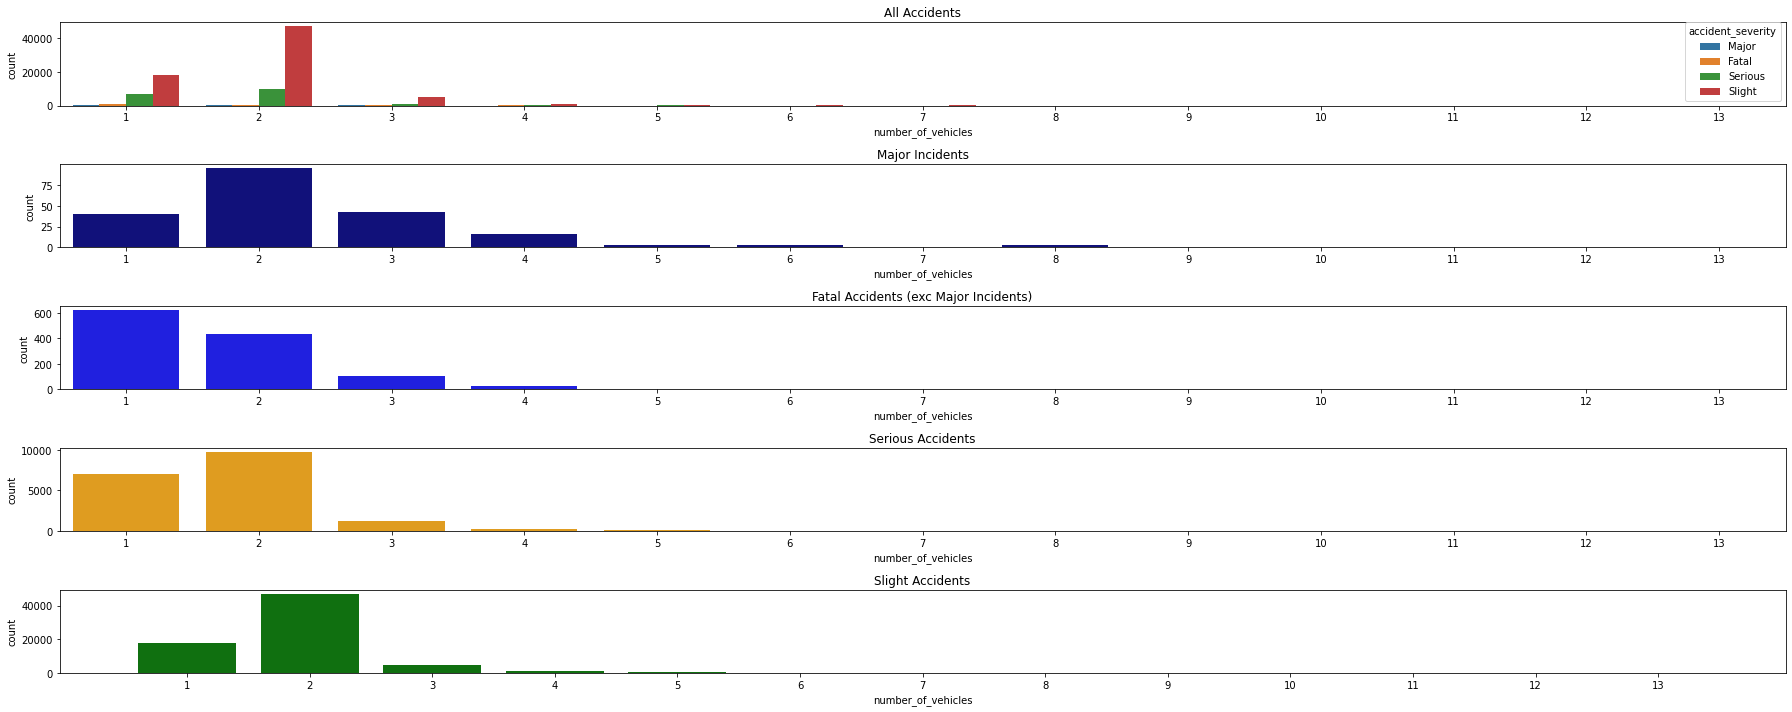

In [19]:
accidents_vehicles = accidents_clean[["number_of_vehicles", "accident_severity", "accident_index"]].groupby(["number_of_vehicles", "accident_severity"]).count()
accidents_vehicles.reset_index(inplace = True)
accidents_vehicles.rename(columns = {"accident_index":"count"}, inplace = True)

print_heading("Bar Plots of accidents vs the number of vehicals involved")
fig, axes = plt.subplots(5, figsize = (25,10))
axes[0].set_title("All Accidents")
_=sns.barplot(ax = axes[0], data = accidents_vehicles, x = "number_of_vehicles", y = "count", hue = "accident_severity")

axes[1].set_title("Major Incidents")
_=sns.barplot(ax = axes[1], data = accidents_vehicles[accidents_vehicles.accident_severity == "Major"], x = "number_of_vehicles", y = "count", color = "darkblue")

axes[2].set_title("Fatal Accidents (exc Major Incidents)")
_=sns.barplot(ax = axes[2], data = accidents_vehicles[accidents_vehicles.accident_severity == "Fatal"], x = "number_of_vehicles", y = "count", color = "blue")

axes[3].set_title("Serious Accidents")
_=sns.barplot(ax = axes[3], data = accidents_vehicles[accidents_vehicles.accident_severity == "Serious"], x = "number_of_vehicles", y = "count", color = "orange")

axes[4].set_title("Slight Accidents")
_=sns.barplot(ax = axes[4], data = accidents_vehicles[accidents_vehicles.accident_severity == "Slight"], x = "number_of_vehicles", y = "count", color = "green")

plt.tight_layout()

_=plt.plot()

We can see that we often see more vehicals involved with major incidents vs fatal accidents, with there typically being 2 vehicals involved, then 3, followed by just 1 car.
Whereas with fatal accidents with fewer than 3 casulties, we typically see 1 car involved.

********



### What time of day and day of the week do most major incidents happen?

Bar Plots of accidents vs time of day (hour)


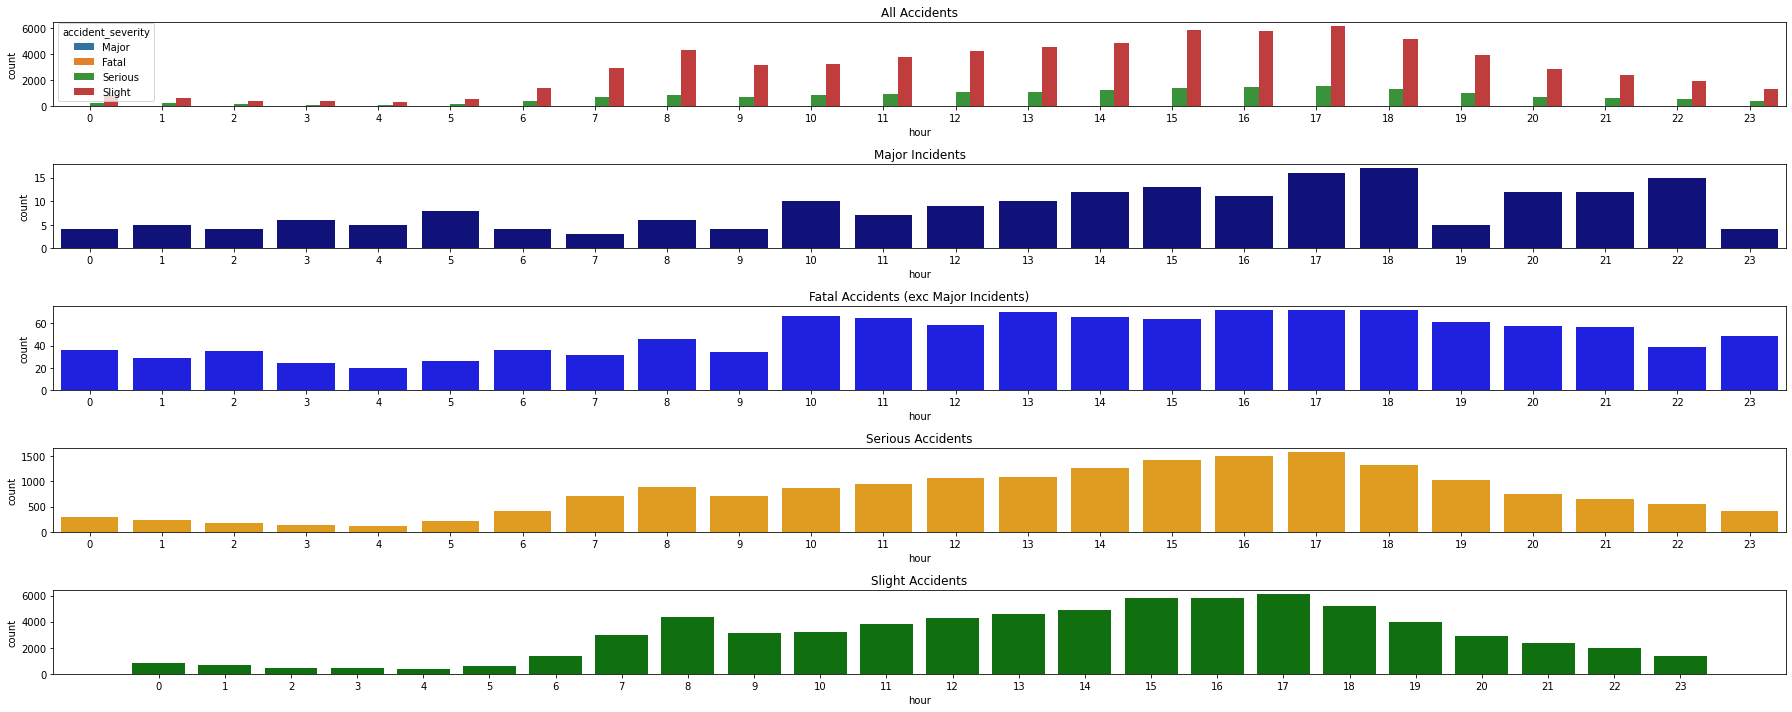

In [20]:
accidents_hour = accidents_clean[["hour", "accident_severity", "accident_index"]].groupby(["hour", "accident_severity"]).count()
accidents_hour.reset_index(inplace = True)
accidents_hour.rename(columns = {"accident_index":"count"}, inplace = True)

print_heading("Bar Plots of accidents vs time of day (hour)")
fig, axes = plt.subplots(5, figsize = (25,10))
axes[0].set_title("All Accidents")
_=sns.barplot(ax = axes[0], data = accidents_hour, x = "hour", y = "count", hue = "accident_severity")

axes[1].set_title("Major Incidents")
_=sns.barplot(ax = axes[1], data = accidents_hour[accidents_hour.accident_severity == "Major"], x = "hour", y = "count", color = "darkblue")

axes[2].set_title("Fatal Accidents (exc Major Incidents)")
_=sns.barplot(ax = axes[2], data = accidents_hour[accidents_hour.accident_severity == "Fatal"], x = "hour", y = "count", color = "blue")

axes[3].set_title("Serious Accidents")
_=sns.barplot(ax = axes[3], data = accidents_hour[accidents_hour.accident_severity == "Serious"], x = "hour", y = "count", color = "orange")

axes[4].set_title("Slight Accidents")
_=sns.barplot(ax = axes[4], data = accidents_hour[accidents_hour.accident_severity == "Slight"], x = "hour", y = "count", color = "green")

plt.tight_layout()
_=plt.plot()

We can see that serious and slight accidents tend to happen throughout the daylight hours, getting worse during peak hours of 9am and then around 4pm to 5pm.

Whilst major incidents and fatal accidents also tend to follow this trend, we can also see that more major incidents and fatal accidents happen in the early hours of the morning compared to other severities.

**Note** Some differences in major incidents and fatal accidents might be due to the volatile nature of having so many fewer major incidents. For example, there's no obvious reason for major accidents to reduce at 7pm.

### Are there any patterns in the time of day/ day of the week when major incidents occur?

Heatmaps showing the number of accidents for any given day and hour


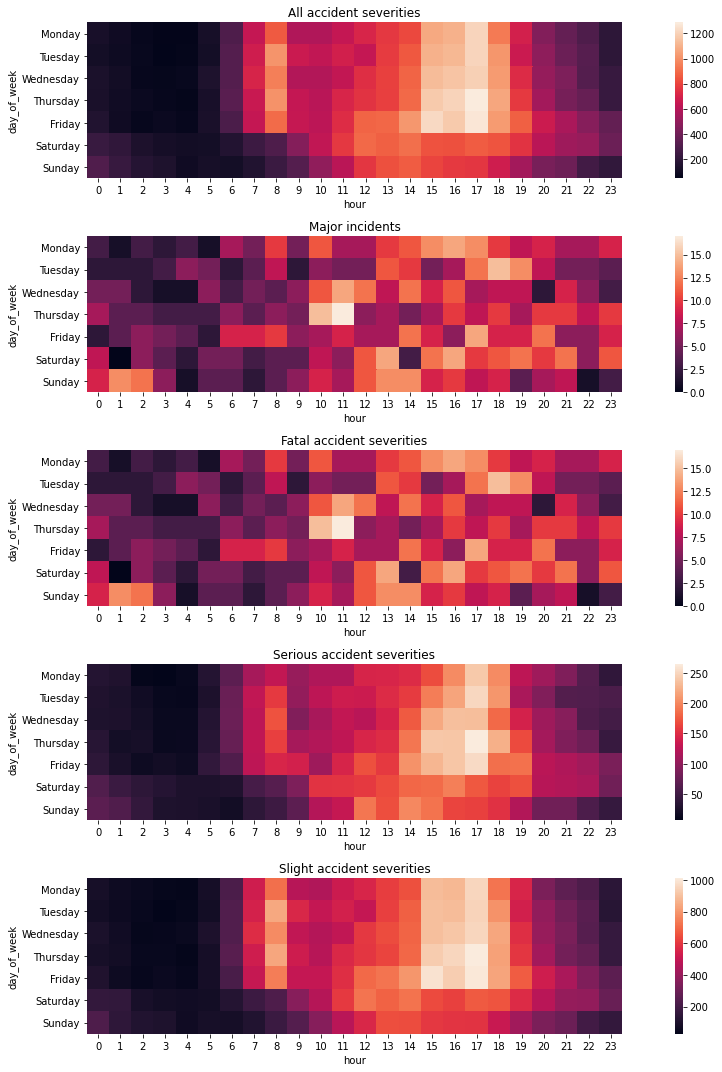

In [21]:
accidents_pattern = accidents_clean[["hour", "day_of_week", "accident_severity", "accident_index"]].groupby(["day_of_week", "hour", "accident_severity"]).count()
#accidents_pattern = accidents_clean[["hour", "day_of_week", "accident_index"]].groupby(["day_of_week", "hour"]).count()
accidents_pattern.reset_index(inplace = True)
accidents_pattern.rename(columns = {"accident_index":"count"}, inplace = True)

accidents_fatal   = accidents_pattern[accidents_pattern.accident_severity == "Fatal"]
accidents_fatal   = accidents_fatal.pivot(columns = "hour", index = "day_of_week", values = "count")

accidents_serious = accidents_pattern[accidents_pattern.accident_severity == "Serious"]
accidents_serious = accidents_serious.pivot(columns = "hour", index = "day_of_week", values = "count")

accidents_slight  = accidents_pattern[accidents_pattern.accident_severity == "Slight"]
accidents_slight  = accidents_slight.pivot(columns = "hour", index = "day_of_week", values = "count")

accidents_all     = accidents_clean[["hour", "day_of_week", "accident_index"]].groupby(["day_of_week", "hour"]).count()
accidents_all.reset_index(inplace = True)
accidents_all.rename(columns = {"accident_index":"count"}, inplace = True)
accidents_all     = accidents_all.pivot(columns = "hour", index = "day_of_week", values = "count")

fig, axes = plt.subplots(5, figsize = (15,15))
print_heading("Heatmaps showing the number of accidents for any given day and hour")
_ = sns.heatmap(ax = axes[0], data = accidents_all, square = True)
axes[0].set_title("All accident severities")

_ = sns.heatmap(ax = axes[1], data = accidents_fatal, square = True)
axes[1].set_title("Major incidents")

_ = sns.heatmap(ax = axes[2], data = accidents_fatal, square = True)
axes[2].set_title("Fatal accident severities")

_ = sns.heatmap(ax = axes[3], data = accidents_serious, square = True)
axes[3].set_title("Serious accident severities")

_ = sns.heatmap(ax = axes[4], data = accidents_slight, square = True)
axes[4].set_title("Slight accident severities")

plt.tight_layout()

_=plt.plot()


We can see a clear pattern in serious and slight accidents, with most accidents happening during the day, mainly around peak time hours monday to friday

There is less of a pattern for major incidents and fatal accidents. Whilst they occur less frequently, there is less of an obvious pattern.

We however can see that there are slightly more accidents Sunday night/early morning and less accidents during the same time period on Monday, with a gradual increase through the week.

### What characteristics stand out in major incidents compared with other accidents?

As we've seen, we see an increase in major incidents compared with other accidents when:
* The vehical is driving at 60mph on an A road
* Occurring more frequently in August
* With the accident likely occuring on a Saturday or Thursday.

### On what areas would you recommend the planning team focus their brainstorming efforts to reduce major incidents?

In order to reduce the number of major incidents, we need to focus not just on features that increase the likelyhood of a major incident, but those features than can increase the likelyhood of a fatal accident or any accident.

* Major Incidents and Fatal Accidents are more likely to occur in Rural Areas.
* Major Incidents and Fatal Accidents occur in the dark more frequently than the other types of severity, however most accidents are during the day.

And all accidents, regardless of severity typically occur when:
* On A Roads, that are a single carriageway.
* When a vehical is travelling either in a 60mph or 30mph speed limit
* During Holiday seasons (Winter and Summer holiday periods)

## Summary
Any accident is one accident too many, especially when it's fatal.

To help reduce major incidents, we should focus on campaigns that focus on
* Vehicals on a single carriageway, typically on A Roads
* Where the speed limit is either 30mph or 60mph
* In rural areas

With the campaign running during holidays (Winter and Christmas), asking drivers to be more careful, especially at weekends.

As most accidents happen on a single carriageway, it would be good to understand why these accidents has occur.  I would guess that many accidents are occurring on rural bendy roads, where there is a national speed limit, but road conditions warrant a speed under this. Perhaps some drivers are inpaitent and overtake other vehicals, without having a clear view of oncoming obstacles or stational objects around a bend or a dip in the road.